## ![Atmospheric Toolbox](https://atmospherictoolbox.org/media/filer_public_thumbnails/filer_public/6d/35/6d35dffd-43f1-43ec-bff6-5aa066c8aabc/toolbox-header.jpg__1080x416_q85_subsampling-2.jpg)

# Atmospheric Toolbox - Gridding TROPOMI Level 2 UV Aerosol Index
 

This use case demonstrates how to create gridded Level 3 netcdf file from one day TROPOMI Level 2 UV Aerosol Index (UVAI, also called as Absorbing Aerosol Index AAI or Aerosol Index AI). This case focuses on an extensive smoke plume from wild fires in Siberia, Russia, on 6th of August 2021. The wild fire smoke extended over a wide area at the Northern high latitudes and therefore the best view on the plume is obtained by gridding TROPOMI data from all the orbits available on that day, a total of 14 files. UVAI is a unitless parameter that is defined based on wavelength dependent changes in Rayleigh scattering in the UV spectral range. Positive values of UVAI indicate the presence of absorbing aerosols, like smoke from biomass burning aerosols or desert dust. In this tutorial the positive UVAI values that we are interested in, are referred as **Absorbing Aerosol Index**. 

In the steps below this tutorial shows 
-  how to read and import TROPOMI Level 2 UVAI with HARP
-  how to grid multiple orbits from one day into a common grid, and save the merged as netcdf file

For more information on TROPOMI UVAI product can be found here:
- [UVAI Algorithm Theoretical Basis](https://sentinels.copernicus.eu/documents/247904/2476257/Sentinel-5P-TROPOMI-ATBD-UV-Aerosol-Index)
- [UVAI Product User Manual](https://sentinels.copernicus.eu/documents/247904/2474726/Sentinel-5P-Level-2-Product-User-Manual-Aerosol-Index-product)

## Initial preparations

To follow this notebook some preparations are needed. The TROPOMI UVAI data used in this notebook is obtained 
from the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home). 

For Sentinel-5P each product file contains the information from one orbit, and there are approximately 14 orbits per day.  In this example we import TROPOMI AAI data from 6th August 2021, and use the following files: 


<i> S5P_OFFL_L2__AER_AI_20210806T003208_20210806T021338_19758_02_020200_20210807T141723.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T021338_20210806T035507_19759_02_020200_20210807T155733.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T035507_20210806T053637_19760_02_020200_20210807T173816.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T053637_20210806T071807_19761_02_020200_20210807T192758.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T071807_20210806T085936_19762_02_020200_20210807T210809.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T085936_20210806T104106_19763_02_020200_20210807T224817.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T104106_20210806T122235_19764_02_020200_20210808T005406.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T122235_20210806T140405_19765_02_020200_20210808T020838.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T140405_20210806T154534_19766_02_020200_20210808T034843.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T154534_20210806T172704_19767_02_020200_20210808T052850.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T172704_20210806T190833_19768_02_020200_20210808T071859.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T190833_20210806T205003_19769_02_020200_20210808T085914.nc <i>    
<i> S5P_OFFL_L2__AER_AI_20210806T205003_20210806T223133_19770_02_020200_20210808T103926.nc <i>
<i> S5P_OFFL_L2__AER_AI_20210806T223133_20210807T001302_19771_02_020200_20210808T121932.nc <i>

**In addition to HARP, this notebook uses several other Python packages that needs to be installed beforehand. The packages needed for running the notebook are:**
- harp: for reading and handling of TROPOMI data
- numpy: for working with arrays 
- matplotlib: for visualizing data
- cartopy: for geospatial data processing, e.g. for plotting maps
- cmcrameri: for universally readable scientific colormaps

**To download the TROPOMI files automatically from the Sentinel-5P Pre-Operations Data Hub:**
    
- sentinelsat: for searching, downloading and retrieving the metadata of Sentinel satellite images from the Copernicus Open Access Hub.

Please note that if you have installed HARP in some specific python environment, check that you have activated the environment before running the scripts.

## Step1: Reading TROPOMI UVAI data using HARP

First the needed Python packages are imported:

In [2]:
import harp
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cmcrameri import cm
import sentinelsat

### Step 1.1: Downloading TROPOMI data with Python (this can be scipped if you have downloaded the files already to your local computer)

In case you have not yet downloaded the UVAI files used in this use case, you can use the sentinelsat-library to automatically donwload the needed files from the Sentinel-5P Pre-Operations Data Hub. In this case we download all 14 UVAI files for 6.8.2021, and use the string 'S5P_OFFL_L2__AER_AI_20210806T*.nc' in the api query. Alternatively, if you would like to download only one file at a time, you can paste the complete filename to the query. Note that the size of each file is about 170 Mb. 

In [58]:
 api = sentinelsat.SentinelAPI('s5pguest', 's5pguest', 'https://s5phub.copernicus.eu/dhus')
 api.download_all(api.query(filename='S5P_OFFL_L2__AER_AI_20210806T*.nc'))   

Fetching archival status: 100%|##########| 14/14 [00:02<00:00,  6.73product/s]

ResultTuple(downloaded={'8d4b0de8-7d14-4c1a-aa8a-dcd1c26a6e03': {'id': '8d4b0de8-7d14-4c1a-aa8a-dcd1c26a6e03', 'title': 'S5P_OFFL_L2__AER_AI_20210806T205003_20210806T223133_19770_02_020200_20210808T103926', 'size': 171351120, 'md5': '400f45bc8b0a708c155d317451bde04e', 'date': datetime.datetime(2021, 8, 6, 21, 11, 38), 'footprint': 'POLYGON((82.02202 50.886024,83.37196 52.139614,84.80453 53.374973,86.32764 54.589935,87.94872 55.782497,89.67643 56.95018,91.51982 58.090122,93.48822 59.199604,95.59181 60.274853,97.84082 61.31228,100.24497 62.30765,102.81461 63.25616,105.55858 64.15262,108.4834 64.991714,111.594635 65.76718,114.893776 66.47292,118.37746 67.10254,122.0375 67.64966,125.86021 68.10775,129.82333 68.47172,133.90019 68.73621,138.05672 68.89766,142.25487 68.953804,146.45401 68.903984,150.61386 68.748276,154.69614 68.4898,158.66676 68.13169,162.49791 67.678925,166.1677 67.136856,169.66168 66.51198,172.97125 65.81056,176.0931 65.039055,179.0287 64.20371,-178.21735 63.310608,-175.637

### Step 1.2: Import the TROPOMI data with HARP

The TROPOMI data is read with HARP using `harp.import_product()` function. First as an example, we import one TROPOMI UVAI file and view its content. Remember to check that the path to the files is correct, pointing to the location of the UVAI files in your own computer, e.g.: 

"/path/to/TROPOMI/S5P_OFFL_L2__AER_AI_20210806T071807_20210806T085936_19762_02_020200_20210807T210809.nc"   

(Note that because the original netcdf file is large, importing the file might take a while.) 



In [3]:
filename = "S5P_OFFL_L2__AER_AI_20210806T071807_20210806T085936_19762_02_020200_20210807T210809.nc"
uvai_data = harp.import_product(filename)

After a succesfull import, you have created a python variable called `uvai_data`. The variable contains a record of the UVAI product variables, and the data is imported as numpy arrays. You can view the contents of `uvai_data` using the Python `print()` function:

In [4]:
print(uvai_data)

source product = 'S5P_OFFL_L2__AER_AI_20210806T071807_20210806T085936_19762_02_020200_20210807T210809.nc'

int scan_subindex {time=1877850}
double datetime_start {time=1877850} [seconds since 2010-01-01]
float datetime_length [s]
int orbit_index
long validity {time=1877850}
float latitude {time=1877850} [degree_north]
float longitude {time=1877850} [degree_east]
float latitude_bounds {time=1877850, 4} [degree_north]
float longitude_bounds {time=1877850, 4} [degree_east]
float sensor_latitude {time=1877850} [degree_north]
float sensor_longitude {time=1877850} [degree_east]
float sensor_altitude {time=1877850} [m]
float solar_zenith_angle {time=1877850} [degree]
float solar_azimuth_angle {time=1877850} [degree]
float sensor_zenith_angle {time=1877850} [degree]
float sensor_azimuth_angle {time=1877850} [degree]
float surface_altitude {time=1877850} [m]
float surface_altitude_uncertainty {time=1877850} [m]
float surface_pressure {time=1877850} [Pa]
float surface_meridional_wind_velocity {t

With print command you can also inspect the information of a specific UVAI product variable (listed above), e.g. by typing: 

In [13]:
print(uvai_data.absorbing_aerosol_index)

type = float
dimension = {time=1877850}
unit = ''
valid_min = -inf
valid_max = inf
description = 'aerosol index'
data =
[nan nan nan ... nan nan nan]



From the listing above you see e.g. that the `absorbing aerosol index` has no unit. The index values can be either negative or positive. 

HARP has builtin converters for [a lot of atmospheric data products](http://stcorp.github.io/harp/doc/html/ingestions/index.html). For each conversion the HARP documentation contains a description of the variables it will return and how it mapped them from the original product format. The description for the product that we ingested can be found in the [S5P_L2_UVAI](http://stcorp.github.io/harp/doc/html/ingestions/S5P_L2_AER_AI.html) description. HARP does this conversion such that data from other satellite data products, such as OMI, or GOME-2, will end up having the same structure and naming conventions. This makes it a lot easier for users to deal with data coming from different satellite instruments.

## Step 2: Regridding TROPOMI Level 2 UVAI with HARP

**One of the main features of HARP is the ability to perform operations as part of the data import.** This feature of HARP allows you to apply different kind of operations on the data already when importing it, and hence, no post processing is needed. These operations include e.g. cutting the data over certain area, converting units, applying the quality flags, and also perform gridding. Information on all operations that can be applied can be found in the [HARP operations documentation](http://stcorp.github.io/harp/doc/html/operations.html). 



### Step 2.1: Operations in HARP import


**Filtering and gridding of TROPOMI Level 2 data is done by including specific operations to the `harp.import_product()` function**. Another example on how to use various operations in `harp.import_product()` can be found from [Use Case 1](https://atmospherictoolbox.org/usecases/usecase1/). In this case the following operations will be performed by HARP while the data is being read, and before it is returned to Python: 
 
**1)** `absorbing_aerosol_index_validity>80` : we only consider pixels for which the data quality is high enough. The basic **quality flag** in any TROPOMI Level 2 netcdf file is given as `qa_value`. In the [Product Readme File for UV Aerosol Index](https://sentinels.copernicus.eu/documents/247904/3541451/Sentinel-5P-Aerosol-Level-2-Product-Readme-File) you can find, that the basic recommendation for UVAI data is to use only those pixels where `qa_value > 0.8`. When HARP imports data, the quality values are interpreted as numbers between 0 and 100 (not 0 and 1), hence our limit in this case is 80. In HARP the `qa_value` is renamed as `absorbing_aerosol_index_validity`.

**2)** `latitude>0` : Ingest data only over Northern hemisphere.

**3)**  `derive(datetime_stop {time} [days since 2000-01-01])` and `derive(datetime_start [days since 2000-01-01])`: derive new variables from the data.  

**4)** `exclude(datetime_length)`: exclude variable that is not needed. 

**5)** `keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,absorbing_aerosol_index)`: keep only selected variabled from the original netcdf files. HARP uses weighted area average to calculate the value for each new grid cell, and therefore the corner coordinates of each satellite pixel, provided by the latitude and longitude bounds are needed. 

**6)** `bin_spatial(81,50,0.5,721,-180,0.5)` : Defining the common Level 3 grid to combine the data from multiple orbits from one day into a single daily grid.  More detailed explanation below. 

**7)** `derive(latitude {latitude})`and `derive(latitude {latitude})`:  Derive lat and lon of the new common grid.
 




####  The bin_spatial () operation and defining the new grid

The regridding is done by using a `bin_spatial()` operation when importing data with HARP. The `bin_spatial()``
 operation requires six input parameters that define the new grid:
- the number of latitude _edge_ points
- the latitude offset at which to start the grid
- the latitude increment (= latitude length of a grid cell)
- the number of longitude _edge_ points
- the longitude offset at which to start the grid
- the longitude increment (= longitude length of a grid cell)

In this example we define a new grid at 0.5 degrees resolution over the area covering the Northern hemisphere between 50N an 90 N. The latitude and longitude offset in this case is for latitude 50N, and for longitude -180W. Since the grid resolution is now 0.5 degrees and the latitudes in the new grid extend from 50N to 90N, the number of latitude edge points is 81 (= 1+(90-50)/0.5 i.e. number of points from 50 to 90 at 0.5 steps). Similarly, since the longitudes in the grid extend from -180W to 180E, the number of longitude edge points is 721 (= 1+(180+180)/0.5). Hence, the number edge points is one more than the number of grid cells. This is similar to the way you should provide the `X` and `Y` parameters to the `pcolormesh` function (see [matplotlib documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html)). Another example of defining a common grid can be found from [Use case 1, Step 4](https://atmospherictoolbox.org/usecases/usecase1/).

In this example, the `bin_spatial()` input is:

`bin_spatial(81, 50, 0.5, 721, -180, 0.5)` 



#### Join the operations

In the following, the HARP operations that are performed when importing data are given as "operations" variable, that includes each HARP operation (name, condition) as string. All the applied HARP operation strings are separated with ";" and finally joined together with python `join()` command. The "operations" variable will be given as input to the `harp.import_product()` function. 

In [9]:
operations = ";".join([
    "absorbing_aerosol_index_validity>80",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,absorbing_aerosol_index)",
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "exclude(datetime_length)",
    "bin_spatial(81,50,0.5,721,-180,0.5)",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])

#### Create the merged product: reduce_operations

This example uses aerosol index data from 14 orbits and HARP will concatenate these products together. However, to arrive at a common lat/lon grid, HARP needs to reduce these 14 orbit grids into a **single grid**. This is done by adding the `reduce_operations` parameter to the `harp.import_product()` function. The reduce_operations parameter can be constructed in a similar manner as the operations parameter, by separating the strings with ";". To create the merged data set, the following reduced operations will be applied:


**1)** `squash(time, (latitude, longitude, latitude_bounds, longitude_bounds))`: Remove the given dimension for the variable, assuming that the content for all items in the given dimension is the same.

**2)** `bin()`: to perform the actual merging. 

In [10]:
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"

### 2.2 The HARP import command

Now that all the elements for `harp.import_product()` function are defined, the import command needs to be applied to all 14 TROPOMI UVAI files. When the files have all been stored in the same folder, importing the data is simple, just give the path (if needed) and the common part of the file names.

In [11]:
filenames = "S5P_OFFL_L2__AER_AI_20210806T*.nc"

When gridding and merging several TROPOMI files execution of `harp.import_product()` may take a while, especially if the grid covers large area and/or the grid cell size is small. Now, the whole import command can be executed as : 

In [12]:
merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)

You can view the contents of the merged_data by:

In [13]:
print(merged)

history = "2021-10-20T14:28:32Z [harp-1.11] harp.import_product('S5P_OFFL_L2__AER_AI_20210806T*.nc',operations='absorbing_aerosol_index_validity>80;keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,absorbing_aerosol_index);derive(datetime_stop {time} [days since 2000-01-01]);derive(datetime_start [days since 2000-01-01]);exclude(datetime_length);bin_spatial(81,50,0.5,721,-180,0.5);derive(latitude {latitude});derive(longitude {longitude})',reduce_operations='squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()')"

double datetime_start {time=1} [days since 2000-01-01]
double absorbing_aerosol_index {time=1, latitude=80, longitude=720} []
double datetime_stop {time=1} [days since 2000-01-01]
long count {time=1}
float weight {time=1, latitude=80, longitude=720}
double latitude_bounds {latitude=80, 2} [degree_north]
double longitude_bounds {longitude=720, 2} [degree_east]
double latitude {latitude=80} [degree_north]
double longitude {longitude=720

As the print of the variables show, the re-gridded `absorbing_aerosol_index` variable has now two dimensions (in addition to time), latitude (80) and longitude (720). Hence, now it is possible to use `pcolormesh` function since the `absorbing_aerosol_index` is a 2D array.

The corner coordinates of each grid cell are provided by the `latitude_bounds` and `longitude_bounds` variables and these are used for plotting. Note that the `pcolormesh` function requires these corner coordinates as the input for latitude and longitude. As we see from the print above, the shape (dimensions) of `latitude_bounds` is 80 x 2, and `longitude_bounds` is 720 x 2. The `regridded_product.latitude_bounds.data[:,0]` array gives the latitudes of the lower corners, whereas `regridded_product.latitude_bounds.data[:,1]` gives the latitudes for upper corners. 

In [41]:
print(merged.latitude_bounds.data[:,0])
print(merged.latitude_bounds.data[:,1])

[50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5
 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5
 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5
 71.  71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.  77.5
 78.  78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.  84.5
 85.  85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5]
[50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5 57.
 57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5 64.
 64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.
 71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.  77.5 78.
 78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.  84.5 85.
 85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5 90. ]


As we see from the print, `merged.latitude_bounds.data[:,1]` contains the j+1 coordinates of the first dimension ([:,0]) plus the upper right corner latitude of the grid. 
To get the correct input for `pcolormesh`, we define the `gridlat` variable by appending the `merged.latitude_bounds.data[:,0]` array with the last element of the second array: `merged.latitude_bounds.data[-1,1]`. The `gridlon` variable is defined similarly: 

In [43]:
gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])

## Step 3: Plottig the gridded data with plocormesh

We use cartopy to and `pcolormesh` function to visualise the merged AAI data on a map. The parameter we want to plot is the `absorbing_aerosol_index`. 

First, the AAI data variable and lat/lon grid are defined. The corner coordinates of each pixel are provided by the latitude_bounds and longitude_bounds variables. In addition, description of the aerosol index data are read that are needed for the colorbar label. 

For plotting, a colormap named `devon` is chosen from the [cmcrameri library](https://www.fabiocrameri.ch/colourmaps/). With vmin and vmax scaling of the colormap values are defined. Positive values of AAI (>1) indicate the presence of absorbing aerosols at elevated amounts (in this case smoke), and  therefore we limit the colorscale with vmin=1. 

In [14]:
AAIval = merged.absorbing_aerosol_index.data
gridlat = np.append(merged.latitude_bounds.data[:,0], merged.latitude_bounds.data[-1,1])
gridlon = np.append(merged.longitude_bounds.data[:,0], merged.longitude_bounds.data[-1,1])
AAIdescription = merged.absorbing_aerosol_index.description

colortable = cm.devon_r

vmin = 1
vmax = 4

By using matplotlib `figsize` argument the figure size can be defined. `plt.axes` set up GeoAxes, in this case the projection is `NorthPolarStereo` from cartopy. The area of interest is set by `set_extent` where the range for latitude and longitude for the plot are given. The actual data is plotted with `plt.pcolormesh` command. Note that the dimensions of the `absorbing_aerosol_index` are time, lat and lon, and therefore the input is given as `AAIval[0,:,:]`. Finally the colorbar is added with label text, and also the location of the colorbar is set. 

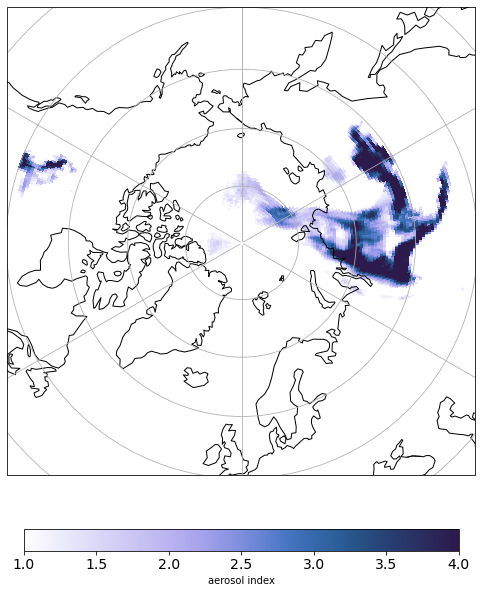

In [15]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

img = plt.pcolormesh(gridlon, gridlat, AAIval[0,:,:], vmin=vmin, vmax=vmax,
                         cmap=colortable, transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

cbar = fig.colorbar(img, ax=ax,orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(f'{AAIdescription}')
cbar.ax.tick_params(labelsize=14)
plt.show()

The plot shows how wide the smoke plume originating from wildfires in Siberian is on 6th August 2021.

### Save gridded data to netcdf

You can also save the results to a netcdf file. The data is saved by using HARP export command `harp.export_product`.

In [46]:
harp.export_product(merged, 's5p-AAI-2021Aug06_wildfire.nc')